# PREPAID CHURN - Prediction

## Initialization of Spark session

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [3]:
import sys, os
sys.path

['',
 '/var/SP/data/home/carnaum2/artifacts/graphframes.zip',
 '/opt/cloudera/parcels/SPARK2/lib/spark2/python',
 '/opt/cloudera/parcels/SPARK2/lib/spark2/python/lib/py4j-0.10.4-src.zip',
 '/var/SP/data/home/carnaum2/artifacts/bda-core-ra-complete-assembly-2.0.0.jar',
 '/var/SP/data/home/carnaum2',
 '/var/SP/data/home/carnaum2/repositorios/use-cases/churn/models/operators/Notebooks/PrepaidModels',
 '/opt/cloudera/parcels/Anaconda-2.5.0/lib/python27.zip',
 '/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7',
 '/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/plat-linux2',
 '/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/lib-tk',
 '/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/lib-old',
 '/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/lib-dynload',
 '/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages',
 '/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/Sphinx-1.3.5-py2.7.egg',
 '/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages

In [4]:
USECASES_SRC = os.path.join(os.environ.get('BDA_USER_HOME', ''), "repositorios", "use-cases")
if USECASES_SRC not in sys.path: 
    sys.path.append(USECASES_SRC)

In [2]:
from common.src.main.python.utils.hdfs_generic import *
import os

MAX_N_EXECUTORS=15
MIN_N_EXECUTORS=1
N_CORES_EXECUTOR=4
EXECUTOR_IDLE_MAX_TIME=120
EXECUTOR_MEMORY='32g'
DRIVER_MEMORY='16g'
N_CORES_DRIVER=1
MEMORY_OVERHEAD=N_CORES_EXECUTOR*2048
#QUEUE="root.datascience.normal"
QUEUE="root.BDPtenants.es.medium"

BDA_CORE_VERSION="1.0.0"

SPARK_COMMON_OPTS=os.environ.get('SPARK_COMMON_OPTS', '')
SPARK_COMMON_OPTS+=" --executor-memory %s --driver-memory %s" % (EXECUTOR_MEMORY, DRIVER_MEMORY)
SPARK_COMMON_OPTS+=" --conf spark.shuffle.manager=tungsten-sort"
SPARK_COMMON_OPTS+="  --queue %s" % QUEUE
APP_NAME='PrepaidChurnPrediction'

# Dynamic allocation configuration
SPARK_COMMON_OPTS+=" --conf spark.driver.allowMultipleContexts=true"
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.enabled=true"
SPARK_COMMON_OPTS+=" --conf spark.shuffle.service.enabled=true"
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.maxExecutors=%s" % (MAX_N_EXECUTORS)
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.minExecutors=%s" % (MIN_N_EXECUTORS)
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.executorIdleTimeout=%s" % (EXECUTOR_IDLE_MAX_TIME)
SPARK_COMMON_OPTS+=" --conf spark.ui.port=58201"
SPARK_COMMON_OPTS+=" --conf spark.port.maxRetries=200"
SPARK_COMMON_OPTS+=" --executor-cores=%s" % (N_CORES_EXECUTOR)
SPARK_COMMON_OPTS+=" --conf spark.app.name=%s" % (APP_NAME)

BDA_ENV = os.environ.get('BDA_USER_HOME', '')

# Attach bda-core-ra codebase
SPARK_COMMON_OPTS+=" --files \
{}/scripts/properties/red_agent/nodes.properties,\
{}/scripts/properties/red_agent/nodes-de.properties,\
{}/scripts/properties/red_agent/nodes-es.properties,\
{}/scripts/properties/red_agent/nodes-ie.properties,\
{}/scripts/properties/red_agent/nodes-it.properties,\
{}/scripts/properties/red_agent/nodes-pt.properties,\
{}/scripts/properties/red_agent/nodes-uk.properties".format(*[BDA_ENV]*7)

os.environ["SPARK_COMMON_OPTS"] = SPARK_COMMON_OPTS
os.environ["PYSPARK_SUBMIT_ARGS"] = "%s pyspark-shell " % SPARK_COMMON_OPTS

#print os.environ.get('SPARK_COMMON_OPTS', '')
#print os.environ.get('PYSPARK_SUBMIT_ARGS', '')

sc, sparkSession, sqlContext = run_sc()
print sc.defaultParallelism

2


In [3]:
# This literal_eval is needed since 
# we have to read from a textfile
# which is formatted as python objects.
# It is totally safe.
from ast import literal_eval

# Standard Library stuff:
from functools import partial
from datetime import date, timedelta, datetime

# Numpy stuff
from numpy import (nan as np_nan, round as np_round, int64 as np_int64)
import numpy as np


# Spark stuff
from pyspark.sql import SparkSession
from pyspark import StorageLevel
from pyspark.sql.functions import (udf, col, decode, when, lit, lower, upper, concat,
                                   translate, count, sum as sql_sum, max as sql_max, min as sql_min,
                                   round, 
                                   mean, stddev, datediff,
                                   length,
                                   countDistinct,
                                   hour, date_format, collect_set, collect_list,
                                   year, month, dayofmonth,
                                   rank, expr, lag, coalesce, row_number,
                                   isnull, isnan,
                                   unix_timestamp,
                                   regexp_replace
                                  )
from pyspark.sql.types import DoubleType, StringType, IntegerType, ArrayType, FloatType

from pyspark.ml import Pipeline

from pyspark.sql import DataFrameStatFunctions as statFunc

from pyspark.sql.window import Window

import json
from collections import OrderedDict

from subprocess import Popen, PIPE
import datetime, calendar
from pyspark.sql import functions as F

from pyspark.ml.feature import StandardScaler


In [4]:
spark = (SparkSession.builder
         .master("yarn")
         .config("spark.submit.deployMode", "client")
         .config("spark.ui.showConsoleProgress", "true")
         .enableHiveSupport()
         .getOrCreate()
         )


In [5]:
from datetime import datetime
start_time = datetime.now()     

## Lectura de las tablas que contiene la información agregada de clientes de prepago

In [ ]:
prepaid = spark.read.table('tests_es.carnaum2_churn_prepago_ids')

---------------

In [ ]:
prepaid.groupBy('Churned').count().show()

In [ ]:
prepaid_final = (prepaid
           .filter( (col('TOTAL_LLAMADAS_previo_M_2') >= 4) )
           .filter( (col('TOTAL_LLAMADAS_previo_M_3') >= 4) )
           .filter( (col('TOTAL_LLAMADAS_previo_M_4') >= 4) )
           .filter(col('data_mb_M-2') > 60)
           .filter(col('data_mb_M-3') > 60)
           .filter(col('data_mb_M-4') > 60)
                    
           .withColumn("diff_saldo", col("diff_saldo_M-4") - col("diff_saldo_M-2"))
           .withColumn("diff_saldo_M-1", col("diff_saldo_M-2") - col("diff_saldo_M-1"))
           .withColumn("diff_saldo_M-2", col("diff_saldo_M-3") - col("diff_saldo_M-2"))
           .withColumn("diff_saldo_M-3", col("diff_saldo_M-4") - col("diff_saldo_M-3"))
           
           .withColumn("diff_abal", col("abal_payment_M-4") - col("abal_payment_M-2"))
           .withColumn("diff_abal_num", col("abal_payment_num_M-4") - col("abal_payment_num_M-1"))
           .withColumn("diff_abal_payment_num_M-1", col("abal_payment_num_M-2") - col("abal_payment_num_M-1"))
           .withColumn("diff_abal_payment_num_M-2", col("abal_payment_num_M-3") - col("abal_payment_num_M-2"))
           .withColumn("diff_abal_payment_num_M-3", col("abal_payment_num_M-4") - col("abal_payment_num_M-3"))

           
           .withColumn("diff_data_mb", col("data_mb_M-4") - col("data_mb_M-2"))
           .withColumn("diff_data_M-1", col("data_mb_M-2") - col("data_mb_M-1"))
           .withColumn("diff_data_M-2", col("data_mb_M-3") - col("data_mb_M-2"))
           .withColumn("diff_data_M-3", col("data_mb_M-4") - col("data_mb_M-3"))
           
           .withColumn('diff_tu_amount', col("tu_amount_M-4") - col("tu_amount_M-2"))
           .withColumn('diff_tu_amount_M-1', col("tu_amount_M-2") - col("tu_amount_M-1"))
           .withColumn('diff_tu_amount_M-2', col("tu_amount_M-3") - col("tu_amount_M-2"))
           .withColumn('diff_tu_amount_M-3', col("tu_amount_M-4") - col("tu_amount_M-3"))
           
           .withColumn('diff_tu_num', col("tu_num_M-4") - col("tu_num_M-2"))
           .withColumn('diff_tu_num_M-1', col("tu_num_M-2") - col("tu_num_M-1"))
           .withColumn('diff_tu_num_M-2', col("tu_num_M-3") - col("tu_num_M-2"))
           .withColumn('diff_tu_num_M-3', col("tu_num_M-4") - col("tu_num_M-3"))
                    
           .withColumn("dff_voice_num", col("voice_num_M-4") - col("voice_num_M-2"))
           .withColumn("dff_voice_num_M-1", col("voice_num_M-2") - col("voice_num_M-1"))
           .withColumn("dff_voice_num_M-2", col("voice_num_M-3") - col("voice_num_M-2"))
           .withColumn("dff_voice_num_M-3", col("voice_num_M-4") - col("voice_num_M-3"))
           
           .withColumn("diff_MOU", col("MOU_previo_M_4") - col("MOU_previo_M_2"))
           #.withColumn("diff_MOU_M-1", col("MOU_previo_M_2") - col("MOU_previo_M_1"))
           .withColumn("diff_MOU_M-2", col("MOU_previo_M_3") - col("MOU_previo_M_2"))
           .withColumn("diff_MOU_M-3", col("MOU_previo_M_4") - col("MOU_previo_M_3"))
           
           .withColumn("diff_LLAMADAS", col("TOTAL_LLAMADAS_previo_M_4") - col("TOTAL_LLAMADAS_previo_M_2"))
           #.withColumn("diff_LLAMADAS_M-1", col("TOTAL_LLAMADAS_previo_M_2") - col("TOTAL_LLAMADAS_previo_M_1"))
           .withColumn("diff_LLAMADAS_M-2", col("TOTAL_LLAMADAS_previo_M_3") - col("TOTAL_LLAMADAS_previo_M_2"))
           .withColumn("diff_LLAMADAS_M-3", col("TOTAL_LLAMADAS_previo_M_4") - col("TOTAL_LLAMADAS_previo_M_3"))
           
           .withColumn("diff_num_conexiones", col("num_conexions_M-4") - col("num_conexions_M-2"))
           .withColumn("diff_num_conexiones_M-1", col("num_conexions_M-2") - col("num_conexions_M-1"))
           .withColumn("diff_num_conexiones_M-2", col("num_conexions_M-3") - col("num_conexions_M-2"))
           .withColumn("diff_num_conexiones_M-3", col("num_conexions_M-4") - col("num_conexions_M-3"))
           
           .withColumn("diff_llam_OOM", col("LLAM_OOM_previo_M_4") - col("LLAM_OOM_previo_M_2"))
           #.withColumn("diff_llam_OOM_M-1", col("LLAM_OOM_previo_M_2") - col("LLAM_OOM_previo_M_1"))
           .withColumn("diff_llam_OOM_M-2", col("LLAM_OOM_previo_M_3") - col("LLAM_OOM_previo_M_2"))
           .withColumn("diff_llam_OOM_M-3", col("LLAM_OOM_previo_M_4") - col("LLAM_OOM_previo_M_3"))
           
           .withColumn("diff_llam_MOU_OOM", col("MOU_OOM_previo_M_4") - col("MOU_OOM_previo_M_2"))
           #.withColumn("diff_llam_MOU_OOM_M-1", col("MOU_OOM_previo_M_2") - col("MOU_OOM_previo_M_1"))
           .withColumn("diff_llam_MOU_OOM_M-2", col("MOU_OOM_previo_M_3") - col("MOU_OOM_previo_M_2"))
           .withColumn("diff_llam_MOU_OOM_M-3", col("MOU_OOM_previo_M_4") - col("MOU_OOM_previo_M_3"))
           
           .withColumn("diff_SMS_OOM", col("SMS_OOM_previo_M_4") - col("SMS_OOM_previo_M_2"))
           #.withColumn("diff_SMS_OOM_M-1", col("SMS_OOM_previo_M_2") - col("SMS_OOM_previo_M_1"))
           .withColumn("diff_SMS_OOM_M-2", col("SMS_OOM_previo_M_3") - col("SMS_OOM_previo_M_2"))
           .withColumn("diff_SMS_OOM_M-3", col("SMS_OOM_previo_M_4") - col("SMS_OOM_previo_M_3"))
           
           .withColumn("diff_data_amount", col("data_amount_M-4") - col("data_amount_M-2"))
           .withColumn("diff_data_amount_M-1", col("data_amount_M-2") - col("data_amount_M-1"))
           .withColumn("diff_data_amount_M-2", col("data_amount_M-3") - col("data_amount_M-2"))
           .withColumn("diff_data_amount_M-3", col("data_amount_M-4") - col("data_amount_M-3"))
           
           .withColumn("diff_SMS", col("TOTAL_SMS_previo_M_4") - col("TOTAL_SMS_previo_M_2"))
                             
           .withColumn("num_pospago", col("num_pospago").cast("double"))
           .withColumn("num_prepago", col("num_prepago").cast("double"))
           )

In [ ]:
prepaid_final.groupBy('Churned').count().show()

In [ ]:
prepaid_final.groupBy('month_of_analysis').count().show()

# Tratamiento de nulos.

In [ ]:
categoricalColumns = [item[0] for item in prepaid_final.dtypes if item[1].startswith('string')]
timestampColumns = [item[0] for item in prepaid_final.dtypes if item[1].startswith('timestamp')]

In [ ]:
numericFeats = [item for item in prepaid_final.columns if item not in categoricalColumns]

In [ ]:
numericFeatsFinal = [item for item in numericFeats if item not in timestampColumns]

In [ ]:
numericFeatsFinal.remove('Churned')

In [ ]:
categoricalColumns.remove('msisdn')
categoricalColumns.remove('NUM_CLIENTE')
categoricalColumns.remove('nacionalidad_final')
categoricalColumns.remove('codigo_plan_precios')
categoricalColumns.remove('TIPO_DOCUMENTO')
categoricalColumns.remove('group_M-2')
categoricalColumns.remove('group_M-3')
categoricalColumns.remove('month_of_analysis')
categoricalColumns.remove('fx_prepaid_fx_first_nif')
categoricalColumns.remove('fx_prepaid_fx_first_nc')
categoricalColumns.remove('load_date_M-2')
categoricalColumns.remove('load_date_M-3')

In [ ]:
categorical_included = [item[0] for item in prepaid_final.dtypes if item[1].startswith('string')]

In [ ]:
prepaid_final = prepaid_final.drop(*categoricalColumns+['month_prepaid','year_prepaid'])

In [ ]:
prepaid_final = prepaid_final.fillna('NO IDENT', subset=categorical_included)
prepaid_final = prepaid_final.fillna(0, subset = numericFeatsFinal)

In [ ]:
prepaid_final = spark.read.load('/data/udf/vf_es/churn/portabPropension_model/prepaid_final')

'''
prepaid_final.repartition(300).write.save('/data/udf/vf_es/churn/portabPropension_model/prepaid_final', format='parquet', mode='overwrite')

'''

# Probamos  `GeneralModelTrainer` 

In [ ]:
%load_ext autoreload
%autoreload 2
import sys


sys.path.append('/var/SP/data/home/carnaum2/New_general_model_trainer') 

from new_general_model_trainer import GeneralModelTrainer
from model_outputs import ModelParameters


modeler=GeneralModelTrainer(df=prepaid_final,label_col='Churned', ignore_cols = [] )
modeler.relevelCategoricalVars() #se crea un diccionario que se puede cargar en ejecuciones posteriores

In [ ]:
modeler.generateFeaturesVector()

In [ ]:
modeler.minMaxScale()

In [ ]:
modeler.split_train_test()

In [ ]:
# Nos permite ir re-entrenando modelos sobre el mismo dataset.

# modeler.reset_stages()

In [ ]:
# Vamos a probar con GBTs 

from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, LogisticRegression, LinearSVC

gbt = GBTClassifier(maxIter=25, maxDepth=3, labelCol=modeler.label_col)                                  

rfc = RandomForestClassifier(numTrees=3000, maxDepth=5, labelCol = modeler.label_col)

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.8, labelCol = modeler.label_col)

lsvc = LinearSVC(maxIter=10, regParam=0.1, labelCol = modeler.label_col)

modeler.train(ml_alg = rfc)

In [ ]:
modeler.evaluate()

In [ ]:
modeler.varimp_plot(show=60)

In [ ]:
modeler.roc_plot(modeler.metrics_balanced_test,figsize=(9,6)) #he añadido el primer parámetro

In [ ]:
modeler.predict()

In [ ]:
df = modeler.predictions

In [ ]:
df_classified = (df.withColumn('acierto', when((col('prediction') == col('Churned_without_nulls') ), 1).otherwise(0))
                 .select('msisdn', 'score', 'acierto', 'Churned_without_nulls', 'month_of_analysis'))

In [ ]:
prepaid_final_good = (df_classified.withColumn('Churned_new', when((col('acierto') == 1) & (col('month_of_analysis') == 'Month of training = M-1'),
                                                                   col('Churned_without_nulls')).otherwise(None))
                      .withColumnRenamed('msisdn', 'msisdn_good')
                      .withColumnRenamed('month_of_analysis', 'MoA_good')
                      .drop(*['acierto', 'prediction', 'Churned_without_nulls', 'score']))

In [ ]:
prepaid_final_bad = (df_classified.withColumn('Churned_new', when((col('acierto') == 0) & (col('month_of_analysis') == 'Month of training = M-1'),
                                                                  col('Churned_without_nulls')).otherwise(None))
                     .withColumnRenamed('msisdn', 'msisdn_bad')
                     .withColumnRenamed('month_of_analysis', 'MoA_bad')
                     .drop(*['acierto', 'prediction', 'Churned_without_nulls', 'score']))

In [ ]:
prepaid_final_good.groupBy('Churned_new').count().show()

In [ ]:
prepaid_final_bad.groupBy('Churned_new').count().show()

Puesto que se hará join entre la cartera inicial y la nueva a partir de 'msisdn', es imprescindible eliminar duplicados.

In [ ]:
prepaid_good_feats = prepaid_final_good.join(prepaid_final,
                                             on = ((prepaid0_final_good['msisdn_good'] == prepaid_final['msisdn']) & (prepaid_final_good['MoA_good'] == prepaid_final['month_of_analysis'])),
                                                   how = 'inner').drop('Churned')

In [ ]:
prepaid_bad_feats = prepaid_final_bad.join(prepaid_final,
                                           on = (prepaid_final_bad['msisdn_bad'] == prepaid_final['msisdn']) & (prepaid_final_bad['MoA_bad'] == prepaid_final['month_of_analysis']),
                                           how = 'inner').drop('Churned')

In [ ]:
prepaid_good_feats = prepaid_good_feats.drop('msisdn_good', 'MoA_good')
prepaid_bad_feats = prepaid_bad_feats.drop('msisdn_bad', 'MoA_bad')

In [ ]:


prepaid_good_feats = spark.read.load('/data/udf/vf_es/churn/portabPropension_model/prepaid_good_feats')
prepaid_bad_feats = spark.read.load('/data/udf/vf_es/churn/portabPropension_model/prepaid_bad_feats')

'''
prepaid_good_feats.repartition(300).write.save('/data/udf/vf_es/churn/portabPropension_model/prepaid_good_feats', format='parquet', mode='overwrite')
prepaid_bad_feats.repartition(300).write.save('/data/udf/vf_es/churn/portabPropension_model/prepaid_bad_feats', format='parquet', mode='overwrite')
'''

# M1: Entrenamos sólo aquellas muestras que han sido predichas erróneamente en nuestro anterior modelo.

In [ ]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append('/var/SP/data/home/carnaum2/New_general_model_trainer') 

from new_general_model_trainer import GeneralModelTrainer
from model_outputs import ModelParameters

modeler1=GeneralModelTrainer(df=prepaid_bad_feats,label_col='Churned_new',ignore_cols=[])
modeler1.relevelCategoricalVars() #se crea un diccionario que se puede cargar en ejecuciones posteriores

In [ ]:
modeler1.generateFeaturesVector()

In [ ]:
modeler1.minMaxScale()

In [ ]:
modeler1.split_train_test()

In [ ]:
# Vamos a probar con GBTs 

from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, LogisticRegression

rfc = RandomForestClassifier(numTrees=1500, maxDepth=4, labelCol = modeler1.label_col )

#modeler1.train()

modeler1.train(ml_alg=rfc)

In [ ]:
modeler1.evaluate()

In [ ]:
modeler1.varimp_plot(show=50)

# M2: Entrenamos un modelo con las muestras bien predichas en el modelo inicial.

In [ ]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append('/var/SP/data/home/carnaum2/New_general_model_trainer') 

from new_general_model_trainer import GeneralModelTrainer
from model_outputs import ModelParameters

modeler2=GeneralModelTrainer(df=prepaid_good_feats,label_col='Churned_new',ignore_cols=[])
modeler2.relevelCategoricalVars() #se crea un diccionario que se puede cargar en ejecuciones posteriores

In [ ]:
modeler2.generateFeaturesVector()

In [ ]:
modeler2.minMaxScale()

In [ ]:
modeler2.split_train_test()

In [ ]:
# Vamos a probar con GBTs 

from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, LogisticRegression

rfc = RandomForestClassifier(numTrees=2500, maxDepth=4, labelCol = modeler2.label_col )

modeler2.train(ml_alg=rfc )

In [ ]:
modeler2.evaluate()

In [ ]:
modeler2.varimp_plot(show=50)

In [ ]:
modeler2.predict()

In [ ]:
modeler1.predict()

In [ ]:
m1_predicted = modeler1.predictions

In [ ]:
df = (df_classified.select('month_of_analysis', 'score', 'msisdn')
      .withColumnRenamed('msisdn', 'msisdn_df')
      .withColumnRenamed('month_of_analysis', 'month_of_analysis_df')
      .withColumnRenamed('score', 'score_df')
     ).drop_duplicates(['msisdn_df', 'month_of_analysis_df'])

In [ ]:
m1_predicted = (m1_predicted.select('msisdn', 'month_of_analysis', 'score')
                .withColumnRenamed('msisdn', 'msisdn_m1')
                .withColumnRenamed('score', 'score_m1')
                .withColumnRenamed('month_of_analysis', 'month_of_analysis_m1')
               ).drop_duplicates(['msisdn_m1', 'month_of_analysis_m1'])

In [ ]:
m2_predicted = (modeler2.predictions.select('msisdn', 'month_of_analysis', 'score')
                .withColumnRenamed('msisdn', 'msisdn_m2')
                .withColumnRenamed('score', 'score_m2')
                .withColumnRenamed('month_of_analysis', 'month_of_analysis_m2')
               ).drop_duplicates(['msisdn_m2', 'month_of_analysis_m2'])

In [ ]:
m1_join = m1_predicted.join(df, 
                  on = ((m1_predicted['msisdn_m1']==df['msisdn_df'])
                        &(m1_predicted['month_of_analysis_m1']==df['month_of_analysis_df'])),
                  how = 'inner')

In [ ]:
df_final = m2_predicted.join(m1_join, 
                  on = ((m2_predicted['msisdn_m2']==m1_join['msisdn_df'])
                        &(m2_predicted['month_of_analysis_m2']==m1_join['month_of_analysis_df'])),
                  how = 'inner')

In [ ]:
df_final = df_final.drop(*['msisdn_m2', 'msisdn_m1', 'month_of_analysis_m1', 'month_of_analysis_m2'])

In [ ]:
df_final = df_final.drop_duplicates(['msisdn_df', 'month_of_analysis_df'])

In [ ]:
df_prepared = df_final.join(prepaid_final, 
                            on = ((df_final['msisdn_df']==prepaid_final['msisdn'])
                                  &(df_final['month_of_analysis_df']==prepaid_final['month_of_analysis'])),
                            how = 'inner'
                           )

In [ ]:
df_prepared = df_prepared.select('Churned', 'msisdn', 'NUM_CLIENTE', 'score_m1', 'score_m2', 'score_df', 'month_of_analysis')

In [ ]:
df_prepared.groupBy('Churned').count().show()

In [ ]:
df_prepared.groupBy('month_of_analysis').count().show()

In [6]:

df_prepared= spark.read.load('/data/udf/vf_es/churn/portabPropension_model/df_prepared')


'''
df_prepared.repartition(300).write.save('/data/udf/vf_es/churn/portabPropension_model/df_prepared', format='parquet', mode='overwrite')
'''

"\ndf_prepared.repartition(300).write.save('/data/udf/vf_es/churn/portabPropension_model/df_prepared', format='parquet', mode='overwrite')\n"

# Predecimos con los resultados de los modelos `m1` y `m2`.

In [7]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append('/var/SP/data/home/carnaum2/New_general_model_trainer') 

from new_general_model_trainer import GeneralModelTrainer
from model_outputs import ModelParameters

modeler_final = GeneralModelTrainer(df=df_prepared, label_col='Churned')
modeler_final.relevelCategoricalVars() #se crea un diccionario que se puede cargar en ejecuciones posteriores

label_col is Churned of type int
[Tue Nov 19 10:05:06 2019] Label Churned is numeric, so no need of converting or indexing it


Using default list of 56 identifer columns and columns to ignore of IDS
There are 7 columns in given DataFrame
There are 1 int columns
There are 3 float columns
There are 3 string columns


There are 0 categorical columns
There are 3 numeric columns
[Tue Nov 19 10:05:06 2019] Counting number of distinct values in categorical variables ...


0variable [00:00, ?variable/s]

[Tue Nov 19 10:05:06 2019] Counting number of distinct values in categorical variables ... done
[Tue Nov 19 10:05:06 2019] Detected 0 constant columns: []
[Tue Nov 19 10:05:06 2019] Writing cols_to_relevel to disk cols_to_relevel-20191119100506.txt
[Tue Nov 19 10:05:06 2019] Releveling 0 categorical variables with more than 32 levels, and dropping constant columns: []
[Tue Nov 19 10:05:06 2019] Releveled  0 categorical variables with more than 32 levels, and dropped constant columns


<new_general_model_trainer.GeneralModelTrainer instance at 0x7efc0c3ec4d0>

In [8]:
modeler_final.generateFeaturesVector()

[Tue Nov 19 10:05:08 2019] Counting NULLs in label Churned ...
[Tue Nov 19 10:05:15 2019] Counting NULLs in label Churned ... 401425
[Tue Nov 19 10:05:15 2019] Using column 'pred' to separate NULLs ...
[Tue Nov 19 10:05:15 2019] Using column 'pred' to separate NULLs ... done
[Tue Nov 19 10:05:15 2019] Skipped indexing categorical features ... already done
[Tue Nov 19 10:05:15 2019] Assembling 3 features ...
[Tue Nov 19 10:05:16 2019] Assembling 3 features ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7efc0c3ec4d0>

In [9]:
modeler_final.minMaxScale()

[Tue Nov 19 10:05:16 2019] Applying minMaxScaler to range [0.000000, 1.000000] ...
[Tue Nov 19 10:05:24 2019] Applying minMaxScaler to range [0.000000, 1.000000] ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7efc0c3ec4d0>

In [10]:
modeler_final.split_train_test()

[Tue Nov 19 10:05:24 2019] Found column "pred". Removing prediction rows for training
[Tue Nov 19 10:05:24 2019] Splitting data set into train(70%)/test(30%) ...
[Tue Nov 19 10:05:24 2019] Splitting data set into train(70%)/test(30%) ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7efc0c3ec4d0>

In [11]:
# Nos permite ir re-entrenando modelos sobre el mismo dataset.

#modeler_final.reset_stages()

In [17]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier

GBT = GBTClassifier(maxDepth=3, labelCol=modeler_final.label_col)

rfc = RandomForestClassifier(numTrees=2500, maxDepth=4, labelCol = modeler_final.label_col)

modeler_final.train(ml_alg=rfc)
#modeler_final.train()

[Tue Nov 19 10:06:24 2019] Not found column "pred". Removing null rows for training
[Tue Nov 19 10:06:24 2019] Balancing train data ...
[Tue Nov 19 10:06:28 2019] Sampling DataFrame by column Churned_without_nulls with fractions: {0: 0.009559686155015436, 1: 1.0} ...
[Tue Nov 19 10:06:28 2019] Sampling DataFrame by column Churned_without_nulls with fractions: {0: 0.009559686155015436, 1: 1.0} ... done
[Tue Nov 19 10:06:28 2019] Caching train data ...
[Tue Nov 19 10:06:28 2019] Caching train data ... done
[Tue Nov 19 10:06:28 2019] Balancing test data ...
[Tue Nov 19 10:06:31 2019] Sampling DataFrame by column Churned_without_nulls with fractions: {0: 0.00913792892631373, 1: 1.0} ...
[Tue Nov 19 10:06:31 2019] Sampling DataFrame by column Churned_without_nulls with fractions: {0: 0.00913792892631373, 1: 1.0} ... done
[Tue Nov 19 10:06:31 2019] Caching test data ...
[Tue Nov 19 10:06:31 2019] Caching test data ... done
[Tue Nov 19 10:06:31 2019] Added new stage: RandomForestClassifier_48

<new_general_model_trainer.GeneralModelTrainer instance at 0x7efc0c3ec4d0>

In [18]:
modeler_final.evaluate()

Model Performance Metrics using (balanced) train data
[Tue Nov 19 10:07:03 2019] Predicting data ...
[Tue Nov 19 10:07:03 2019] Using element -1 as positive class
[Tue Nov 19 10:07:03 2019] Predicting data ... done
[Tue Nov 19 10:07:03 2019] Converting evaluation_predictions to Pandas ...
[Tue Nov 19 10:07:35 2019] Converting evaluation_predictions to Pandas ... done
matthews_corrcoef: 0.33866519932639394
f2_score: 0.7033234357671807
jaccard_similarity_score: 0.6685198687568356
precision_score: 0.6534818015622403
classification_report:
              precision    recall  f1-score   support

           0       0.69      0.62      0.65      5488
           1       0.65      0.72      0.68      5484

   micro avg       0.67      0.67      0.67     10972
   macro avg       0.67      0.67      0.67     10972
weighted avg       0.67      0.67      0.67     10972

average_precision_score: 0.7164955001557555
confusion_matrix:
[[3403, 2085], [1552, 3932]]
hinge_loss: 0.9278927427987156
f1_score:

<new_general_model_trainer.GeneralModelTrainer instance at 0x7efc0c3ec4d0>

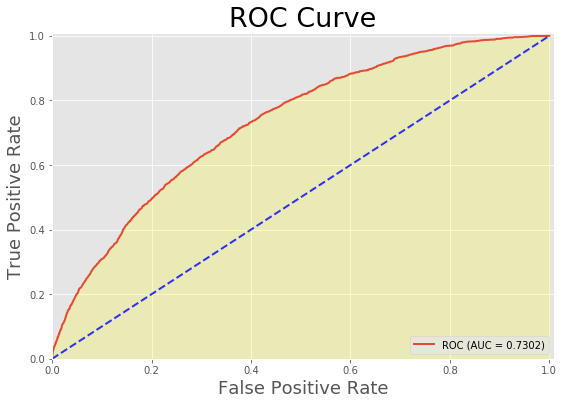

In [19]:
modeler_final.roc_plot(modeler_final.metrics_unbalanced_test ,figsize=(9,6))

<Figure size 648x432 with 0 Axes>

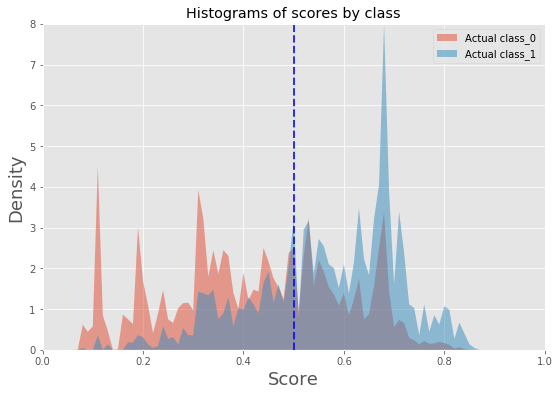

In [20]:
modeler_final.plot_scores_histograms(modeler_final.metrics_unbalanced_test, figsize=(9,6))

In [21]:
evaluation_metrics_balanced_test = modeler_final.metrics_balanced_test

In [22]:
evaluation_metrics_unbalanced_test = modeler_final.metrics_unbalanced_test

In [23]:
evaluation_metrics_train = modeler_final.metrics_train

In [24]:
modeler_final.predict()

[Tue Nov 19 10:10:24 2019] Selecting rows to predict
[Tue Nov 19 10:10:24 2019] Found column "pred". Selecting prediction rows
[Tue Nov 19 10:10:24 2019] Predicting data ...
[Tue Nov 19 10:10:24 2019] Using last element as positive class
[Tue Nov 19 10:10:24 2019] Predicting data ... done


<new_general_model_trainer.GeneralModelTrainer instance at 0x7efc0c3ec4d0>

In [25]:
modeler_final_to_predict = modeler_final.predictions.filter(col('month_of_analysis') == 'Month of prediction = M')

In [26]:
modeler_final_to_train = modeler_final.predictions.filter(col('month_of_analysis') == 'Month of training = M-1')

In [27]:
modeler_final_to_predict.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|267597|
|       1.0|133828|
+----------+------+



In [28]:
modeler_final_to_predict.groupBy('month_of_analysis').count().show()

+--------------------+------+
|   month_of_analysis| count|
+--------------------+------+
|Month of predicti...|401425|
+--------------------+------+



# Generamos los deciles para añadir a la entrega.

In [29]:
from pyspark.sql.functions import monotonically_increasing_id
import numpy as np

## Generación de deciles sobre el Dataframe, únicamente considerando clientes propensos.

def get_deciles(df):
    
    i = 0
    j = 0
    
    lista_msisdn = df.select('msisdn').toPandas()['msisdn'].tolist()
    lista_deciles = []
    
    lista_msisdn
    
    num_propensos = df.filter(col('prediction') == 1).count()
    len_df = df.count()
    decil_amount = np.round(float(num_propensos)/10)
    
    df = df.orderBy('score', ascending=False)
    
    while i < 10:
        
        count = 0 
        
        while count < decil_amount:
            lista_deciles.append('decil='+str(10-i))
            count += 1
        
        i += 1
    
    while j < (len_df - (decil_amount)*10):
        lista_deciles.append('NA')
        j += 1
            
    b = spark.createDataFrame(zip(lista_deciles,lista_msisdn)).withColumnRenamed('_1', 'decil').withColumnRenamed('_2', 'msisdn')
    b = b.withColumn('msisdn', col('msisdn').cast(StringType()))
    
    # Join both dataframes to get the final result
    final_df = df.join(b, on = 'msisdn', how = 'inner')
    
    return final_df

In [30]:
modeler_final_to_predict = get_deciles(modeler_final_to_predict)

# Preparamos datos para exportar en formato `Model Params` y `Model Outputs`.

In [31]:
import time, datetime

## OJO! Esto hay que cambiarlo en función de la entrega a realizar.
closing_day = '20190930'
current_timestamp = datetime.now() 
executed_at = current_timestamp.strftime('%Y-%m-%d %H:%M:%S')
analysis_month_M = datetime.datetime.strptime(closing_day, "%Y%m%d")


In [32]:
level = 'msisdn'

model_name = 'prepaid_churn_Service'

path_model_detail = 'model_name=' + model_name \
                            + '/year=' + str(current_timestamp.year) \
                            + '/month=' + str(current_timestamp.month) \
                            + '/day=0'# + str(current_timestamp.day) #siempre se pone 0 (pongo -1 para las pruebas)


In [34]:
model_params = {
    'algorithm': modeler_final.model.stages[0].getParam,
    'maxdepth': modeler_final.model.stages[0]._java_obj.getMaxDepth(),
    'maxbins': modeler_final.model.stages[0]._java_obj.getMaxBins(),
    'minInstancesPerNode': modeler_final.model.stages[0]._java_obj.getMinInstancesPerNode(),
    'numTrees': modeler_final.model.stages[0]._java_obj.getNumTrees(),
    'subsamplingRate': modeler_final.model.stages[0]._java_obj.getSubsamplingRate(),
    'seed': modeler_final.model.stages[0]._java_obj.getSeed()
}

In [35]:
path_model_outputs_base = '/data/attributes/vf_es/model_outputs/'
path_model_outputs_scores = path_model_outputs_base + 'model_scores/' + path_model_detail
path_model_outputs_params = path_model_outputs_base + 'model_parameters/' + path_model_detail

In [36]:
path_model_works_base = '/user/carnaum2/models_prod/'
path_model_works_model = path_model_works_base + 'model_definition/' + path_model_detail
path_model_works_metrics = path_model_works_base + 'model_metrics/' + path_model_detail

- Saving `Model Params`:

In [38]:
target = "Portabilities out from the prepaid customer base.;"
model_path = path_model_works_model.replace(',', ';')
metrics_path = path_model_works_metrics.replace(',', ';')
metrics_train = str(evaluation_metrics_train).replace(',', ';')
metrics_test = str(evaluation_metrics_unbalanced_test).replace(',', ';')
varimp = ';'.join(str(v) for v in modeler_final.varimp[['feature', 'relative_importance']].values.tolist()).replace(',', ';')
algorithm = str(model_params).replace(',', ';')
author_login = 'carnaum2'
scores_extra_info_headers = None
time = int(current_timestamp.strftime('%H%M%S'))

In [39]:
description = 'Prediction of prepaid customers prone to make a portability (churn) to other company. The periodicity of executions is monthly.'

In [45]:

end_time = datetime.now()         

time_of_execution=end_time-start_time
time_of_execution=str(time_of_execution.total_seconds())


ValueError: invalid literal for int() with base 10: '2019-11-19 10:31:48.393769'

In [49]:
extra_info = '{description:'+description+'; processing_time:'+time_of_execution+'}'

In [50]:
from pyspark.sql.types import *

fields = [StructField("executed_at", StringType(), True),
                  StructField("model_level", StringType(), True),
                  StructField("training_closing_date", StringType(), True),
                  StructField("target", StringType(), True),
                  StructField("model_path", StringType(), True),
                  StructField("metrics_path", StringType(), True),
                  StructField("metrics_train", StringType(), True),
                  StructField("metrics_test", StringType(), True),
                  StructField("varimp", StringType(), True),
                  StructField("algorithm", StringType(), True),
                  StructField("author_login", StringType(), True),
                  StructField("extra_info", StringType(), True),
                  StructField("scores_extra_info_headers", StringType(), True),
                  StructField("time", IntegerType(), True)
                  ]

In [51]:
schema = StructType(fields)

In [52]:
data = [[executed_at, level, closing_day, target, model_path, metrics_path, metrics_train,
                 metrics_test, varimp, algorithm, author_login, extra_info, scores_extra_info_headers, time]]

In [53]:
df_save_params = spark.createDataFrame(data, schema)

In [54]:
def saveDF(path, df, partitions):
    print('Saving started in: %s', path)
    spark.conf.set("spark.sql.sources.partitionOverwriteMode","dynamic")
    df.repartition(partitions).write.mode('append').format('parquet').save(path)
    print('Saving finished!')

In [55]:
saveDF(path_model_outputs_params, df_save_params, 1)

('Saving started in: %s', '/data/attributes/vf_es/model_outputs/model_parameters/model_name=prepaid_churn_Service/year=2019/month=11/day=0')
Saving finished!


- Saving `Model Outputs`:

In [56]:
path_model_outputs_base = '/data/attributes/vf_es/model_outputs/'
path_model_outputs_scores = path_model_outputs_base + 'model_scores/' + path_model_detail
path_model_outputs_sample = '/data/attributes/vf_es/carnaum2/samples/'

In [57]:
df_save_scores = (modeler_final_to_predict
                        # .withColumn('model_name',lit(model_name)) included in path
                        .withColumn('executed_at', lit(executed_at).cast(StringType()))
                        .withColumn('model_executed_at', lit(executed_at).cast(StringType()))
                        .withColumn('predict_closing_date', lit(closing_day).cast(StringType()))
                        .withColumn('msisdn', col('msisdn').cast(StringType()))
                        .withColumn('client_id', col('NUM_CLIENTE').cast(StringType()))
                        .withColumn('nif', lit(None).cast(StringType()))
                        .withColumn('model_output', lit(None).cast(StringType()))
                        .withColumn('scoring', col('score').cast(FloatType()))
                        .withColumn('prediction', col('prediction').cast(StringType()))
                        .withColumn('extra_info', col('decil').cast(StringType()))
                        .withColumn('time', lit(time).cast(IntegerType()))
                        .withColumn('model_name', lit(model_name).cast(StringType()))
                        .select('executed_at', 'model_executed_at', 'predict_closing_date', 'msisdn'
                                       , 'client_id', 'nif', 'model_output', 'scoring', 'prediction'
                                       , 'extra_info', 'time')
                            )

In [58]:
saveDF(path_model_outputs_scores, df_save_scores, 1)

('Saving started in: %s', '/data/attributes/vf_es/model_outputs/model_scores/model_name=prepaid_churn_Service/year=2019/month=11/day=0')
Saving finished!


---

In [59]:
spark.stop()

In [60]:
from datetime import datetime
then = datetime.now()         
now  = datetime.now()                        
duration = now - then                         
duration_in_s = duration.total_seconds() 

In [61]:
duration_in_s

5.5e-05

In [ ]:
predsOrangeTest= spark.read.load('/data/udf/vf_es/churn/portabPropension_model/predsOrangeTest')